# Linear Regression - Real Estate Data Set - Learning Curves

> Joseph P. Vantassel, The University of Texas at Austin

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn import linear_model as lm

## Load Data Set

In [3]:
# load dataframe
df = pd.read_csv("real_estate.csv")

# convert to numpy
xfeatures = df.iloc[:, 1:-1].to_numpy()
ypredict = df.iloc[:, -1].to_numpy()

# make sure we did the slices correctly
print(f"xfeatures.shape = {xfeatures.shape}")
print(f"ypredict.shape = {ypredict.shape}")

xfeatures.shape = (414, 6)
ypredict.shape = (414,)


## Shuffle & Split (Train - Validation - Test)

In [4]:
ptrain, pvalid, ptest = 0.7, 0.15, 0.15

# shuffle
rng = np.random.default_rng(1824)
shuffle_idxs = np.arange(len(ypredict))
rng.shuffle(shuffle_idxs)
xfeatures_shuffled = xfeatures[shuffle_idxs]
ypredict_shuffled = ypredict[shuffle_idxs]

# split
start_idx, stop_idx = 0, int(ptrain*len(ypredict))
xfeatures_train, ypredict_train = xfeatures_shuffled[start_idx: stop_idx], ypredict_shuffled[start_idx: stop_idx]
print(xfeatures_train.shape, ypredict_train.shape)


start_idx, stop_idx = stop_idx, stop_idx+int(pvalid*len(ypredict))
xfeatures_valid, ypredict_valid = xfeatures_shuffled[start_idx: stop_idx], ypredict_shuffled[start_idx: stop_idx]
print(xfeatures_valid.shape, ypredict_valid.shape)


start_idx, stop_idx = stop_idx, -1
xfeatures_test, ypredict_test = xfeatures_shuffled[start_idx: stop_idx], ypredict_shuffled[start_idx: stop_idx]
print(xfeatures_test.shape, ypredict_test.shape)


(289, 6) (289,)
(62, 6) (62,)
(62, 6) (62,)


## Learning Curves

From our prior work we saw the effect of various transformations on linear regression. The last transformation `log10` and `exp` worked pretty well except we did not see much improvement on the validation set, this may be because we do not have enough training examples. One way to test this hypothesis is by looking at the problems learning curves. In essense the learning curve we are going to look at is the loss on the train and validation set as a function of the number of training examples as see how our model improves with the number of samples.

In [18]:
# constant to ensure no divide by zero
eps = 1E-4

def normalize_standardscore(features, means, stds):
    return (features - means)/(stds + eps)
    
def normalize_minmax(features, mins, maxs):
    return (features - mins)/((maxs - mins) + eps)

def normalize_max(features, maxs):
    return features / (maxs + eps)

def rmse(yhat, y):
    return np.sqrt(np.mean(np.power(yhat - y, 2)))

In [24]:
percentiles = np.linspace(0.2, 1, 10)

m = len(xfeatures_train)

nsamples = []
train_rmse = []
valid_rmse = []
for p in percentiles:
    # numer of samples to use
    _nsamples = int(p*m)
    
    # training set
    x_train_tmp = xfeatures_train[:_nsamples]

    # stats
    xmean, xstd = np.mean(x_train_tmp, axis=0), np.std(x_train_tmp, axis=0, ddof=1)
    xmin, xmax = np.min(x_train_tmp, axis=0), np.max(x_train_tmp, axis=0)
    
    # training set
    x_for_train = np.hstack((
         normalize_standardscore(x_train_tmp, xmean, xstd), # normalize between -3 & +3
         np.log10(normalize_max(x_train_tmp, xmax) + 0.5), # normalize between 0 and 1
         np.exp(normalize_minmax(x_train_tmp, xmin, xmax))
    ))
    y_for_train = ypredict_train[:_nsamples]
    
    # validation set
    x_for_valid = np.hstack((
        normalize_standardscore(xfeatures_valid, xmean, xstd), # normalize between -3 & +3
        np.log10(normalize_max(xfeatures_valid, xmax) + 0.5), # normalize between 0 and 1
        np.exp(normalize_minmax(xfeatures_valid, xmin, xmax))
    ))
    y_for_valid = ypredict_valid
    
    lmod = lm.LinearRegression(fit_intercept=True)
    lmod_trained = lmod.fit(x_for_train, y_for_train)
    
    yhat_from_train = lmod_trained.predict(x_for_train)
    yhat_from_valid = lmod_trained.predict(x_for_valid)
    
    nsamples.append(_nsamples)
    train_rmse.append(rmse(yhat_from_train, y_for_train))
    valid_rmse.append(rmse(yhat_from_valid, y_for_valid))

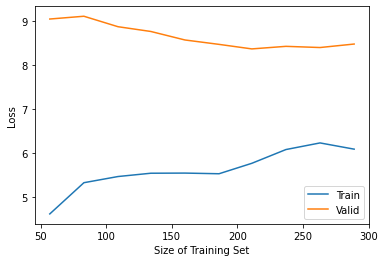

In [25]:
plt.plot(nsamples, train_rmse, label="Train")
plt.plot(nsamples, valid_rmse, label="Valid")
plt.xlabel("Size of Training Set")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Conclusion

We see that we are overfitting our training data meaning that more training samples will help our model. We refer to this model as a high-variance model. As we do not have access to more samples we can try adding regularization to reduce overfitting.